# Feature-Based Analysis for Condition Discrimination

This tutorial demonstrates feature importance and statistical comparisons.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from mea_flow.data import SpikeList
print("✓ Imports successful")

✓ Imports successful


In [14]:
# Create simple synthetic datasets
def create_data(condition, n_datasets=1):
    datasets = []
    base_rate = 1.0 if condition == "control" else 2.0
    
    for i in range(n_datasets):
        np.random.seed(42 + i + (10 if condition == "treatment" else 0))
        spike_data = {}
        
        for ch in range(1, 5):
            rate = base_rate * np.random.uniform(0.8, 1.2)
            n_spikes = int(rate * 10)
            spike_times = np.sort(np.random.uniform(0, 10, n_spikes))
            spike_data[ch] = spike_times
        
        spike_list = SpikeList(spike_data, recording_length=10.0)
        spike_list.metadata = {"condition": condition, "id": i}
        datasets.append(spike_list)
    
    return datasets

control_data = create_data("control")
treatment_data = create_data("treatment1")
treatment_data2 = create_data("treatment2")
all_data = control_data + treatment_data
print(f"Created {len(all_data)} datasets")

Created 2 datasets


In [15]:
# Compute metrics
def compute_metrics(spike_list):
    firing_rates = []
    spike_counts = []
    
    for ch in spike_list.get_active_channels():
        train = spike_list.spike_trains[ch]
        firing_rates.append(train.firing_rate)
        spike_counts.append(train.n_spikes)
    
    return {
        "mean_firing_rate": np.mean(firing_rates) if firing_rates else 0,
        "std_firing_rate": np.std(firing_rates) if len(firing_rates) > 1 else 0,
        "total_spikes": sum(spike_counts),
        "active_channels": len(firing_rates),
        "max_firing_rate": max(firing_rates) if firing_rates else 0,
        "condition": spike_list.metadata["condition"]
    }

all_metrics = [compute_metrics(data) for data in all_data]
metrics_df = pd.DataFrame(all_metrics)
print(f"Metrics shape: {metrics_df.shape}")
metrics_df

Metrics shape: (2, 6)


,mean_firing_rate,std_firing_rate,total_spikes,active_channels,max_firing_rate,condition
0,0.85,0.050000,34,4,0.9,control
1,1.90,0.122474,76,4,2.1,treatment1


In [16]:
# Feature importance
feature_cols = ["mean_firing_rate", "std_firing_rate", "total_spikes", "active_channels", "max_firing_rate"]
X = metrics_df[feature_cols]
y = metrics_df["condition"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_scaled, y)

importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("Feature Importance:")
print(importance_df)

cv_scores = cross_val_score(rf, X_scaled, y, cv=3)
print(f"Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Feature Importance:
            feature  importance
1   std_firing_rate        0.40
0  mean_firing_rate        0.28
2      total_spikes        0.16
4   max_firing_rate        0.16
3   active_channels        0.00


ValueError: Cannot have number of splits n_splits=3 greater than the number of samples: n_samples=2.

In [9]:
# Statistical tests
print("Statistical Comparisons:")
for feature in feature_cols:
    control_vals = metrics_df[metrics_df["condition"] == "control"][feature]
    treatment_vals = metrics_df[metrics_df["condition"] == "treatment"][feature]
    
    statistic, p_value = stats.mannwhitneyu(control_vals, treatment_vals)
    effect_size = abs(treatment_vals.mean() - control_vals.mean())
    
    print(f"{feature}: p={p_value:.3f}, effect={effect_size:.3f}")

Statistical Comparisons:
mean_firing_rate: p=0.100, effect=1.083
std_firing_rate: p=0.700, effect=0.027
total_spikes: p=0.100, effect=43.333
active_channels: p=1.000, effect=0.000
max_firing_rate: p=0.072, effect=1.067


/tmp/ipykernel_180549/288015827.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([control_vals, treatment_vals], labels=["Control", "Treatment"])


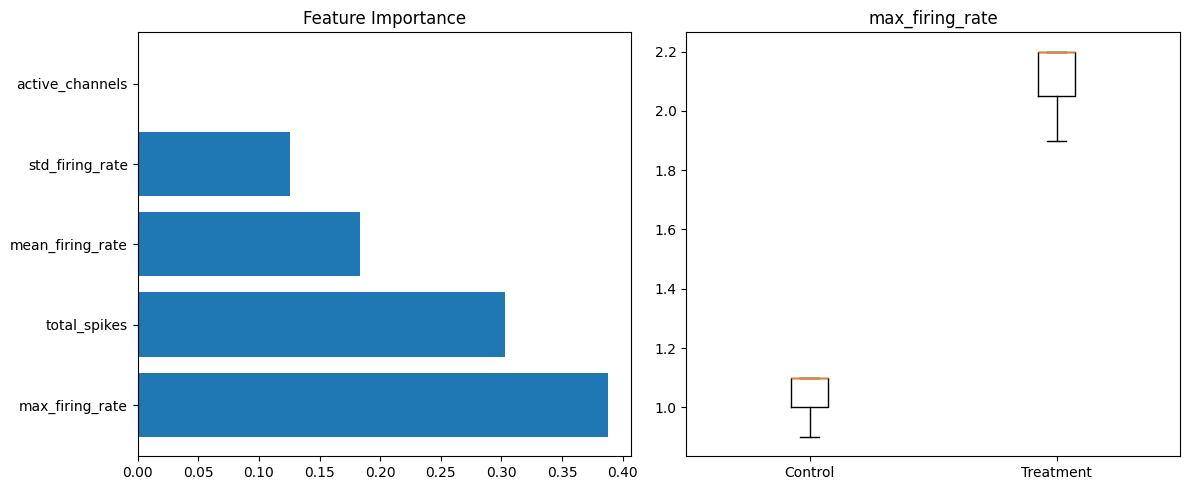

✓ Analysis complete!


In [10]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Feature importance
axes[0].barh(importance_df["feature"], importance_df["importance"])
axes[0].set_title("Feature Importance")

# Box plot for top feature
top_feature = importance_df.iloc[0]["feature"]
control_vals = metrics_df[metrics_df["condition"] == "control"][top_feature]
treatment_vals = metrics_df[metrics_df["condition"] == "treatment"][top_feature]

axes[1].boxplot([control_vals, treatment_vals], labels=["Control", "Treatment"])
axes[1].set_title(f"{top_feature}")

plt.tight_layout()
plt.show()
print("✓ Analysis complete!")